In [1]:
import numpy as np
import os
import random
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
import pathlib
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
import tensorflow_advanced_segmentation_models as tasm
from functools import partial


In [2]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
processed_data           = os.path.join(parent_path, "data/processed/float[0-1]")

In [3]:
images = np.load(processed_data+"/train_images.npy")
masks  = np.load(processed_data+"/train_masks.npy")

In [4]:
import albumentations as A
def augmentation(img_size):
    aug = A.Compose([
            A.RandomCrop(width = img_size, height = img_size, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Transpose(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
            A.RandomBrightnessContrast(p=0.25),
            A.RandomGamma(p=0.25),
            A.IAAEmboss(p=0.25),
            A.Blur(p=0.01, blur_limit = 3),
    #         A.OneOf([
    #             A.ElasticTransform(p=0.5, alpha=400, sigma=400 * 0.05, alpha_affine=400 * 0.03),
    #             A.GridDistortion(p=0.5),
    #             A.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.1)                  
    #         ], p=0.8)
        ], p = 1)
    return aug

def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    return input_image.numpy(), input_mask.numpy()
def augment(input_image, input_mask,img_size):
    data = {"image":input_image,"mask":input_mask}
    aug = augmentation(img_size)
    aug_data = aug(**data)
    input_image = aug_data["image"]
    input_mask = aug_data["mask"]
    return input_image, input_mask

def set_shapes(input_image, input_mask,img_size):
    img_shape=(None,img_size,img_size,3)
    mas_shape=(None,img_size,img_size,1)
    input_image.set_shape(img_shape)
    input_mask.set_shape(mas_shape)
    return input_image, input_mask

def load_image_train(input_image, input_mask,img_size):
    input_image, input_mask = resize(input_image, input_mask)
#     input_image, input_mask = augment(input_image, input_mask,img_size)
    return input_image, input_mask
def load_image_test(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask)
    return input_image, input_mask

def train_prepro(image, mask, img_size):
    aug_img,aug_mask = tf.numpy_function(func=load_image_train, inp=[image, mask, img_size], Tout=[tf.float32,tf.float32])
    return aug_img, aug_mask
def test_prepro(image, mask, img_size):
    image,mask = tf.numpy_function(func=load_image_test, inp=[image, mask], Tout=[tf.float32,tf.float32])
    return image, mask

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(images,masks,test_size=0.15,random_state=42)
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
test_ds = (tf.data.Dataset.from_tensor_slices((X_test, Y_test)))

In [6]:
#Unet
#mobilenet(1,2),Eff5(4,2),Eff0(3,3), resnet50(2,2),xception(shapeerror),mobilenetv2(1,2),densenet121(2,2),densenet201(3,2),vgg1&(1,2)
#DeepLab(loss = - y_true * (alpha * K.pow((1 - y_pred), gamma) * K.log(y_pred)    InvalidArgumentError: required broadcastable shapes [Op:Mul])



In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_size=320
train_length = len(X_train)
batch_size = 16
BUFFER_SIZE = 1000
steps_per_epoch =100
N_CLASSES = 2
BACKBONE_NAME = "mobilenet"
WEIGHTS = "imagenet"
val_batch_size=10
validation_steps = len(Y_test)//val_batch_size
epochs = 20

# create dataset
train = train_ds.map(partial(train_prepro, img_size=img_size),
                  num_parallel_calls=AUTOTUNE)
test = test_ds.map(partial(test_prepro, img_size=img_size))
# create dataset
train_batches = train.cache().shuffle(BUFFER_SIZE).batch(batch_size).repeat().map(partial(set_shapes,img_size=img_size))
validation_batches = test.batch(val_batch_size).map(partial(set_shapes,img_size=img_size))

In [8]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=img_size, width=img_size, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.UNet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=11, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=13, mode="max", verbose=1, restore_best_weights=True)
]

C:\Users\guthr\anaconda\envs\road\lib\site-packages\albumentations\imgaug\transforms.py:175: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


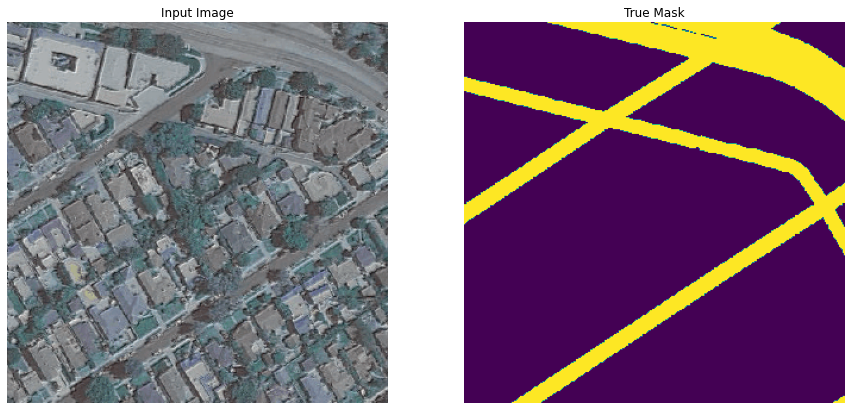

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

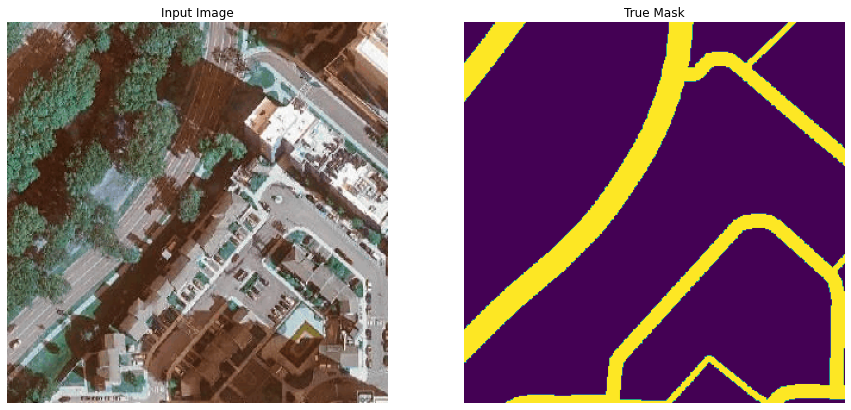

In [11]:
import tensorflow.keras.backend as K
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train_batches.take(2):
    sample_image, sample_mask = image[0], mask[0]
    
display([sample_image, sample_mask])


1/1 [==============================] - 6s 6s/step


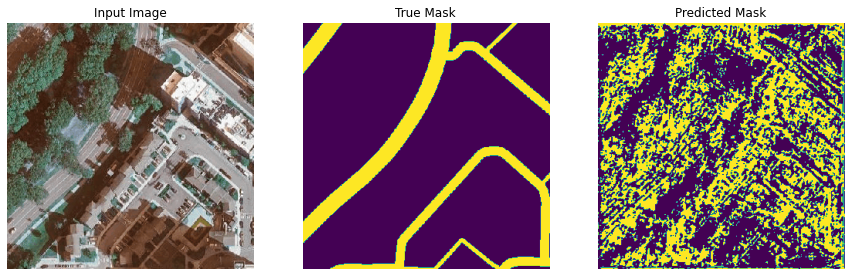

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    # for yet unknown reasons 0s and 1s need to be inverted... something is not working properly in the training pipeline
    # that is why iou_score and val_iou_score are so low while fitting the model...
    pred_mask = pred_mask == 0
    pred_mask = tf.cast(pred_mask, tf.float32)
    return pred_mask[0]

display([
         sample_image,
         sample_mask,
         create_mask(
             model.predict(sample_image[tf.newaxis, ...])
             )
         ])
    

In [13]:
for layer in model.layers:
    if "model" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))
history = model.fit(
    train_batches,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
    )

model: False
convolution_bn_activation: True
convolution_bn_activation_1: True
upsample_x2__block: None
upsample_x2__block_1: None
upsample_x2__block_2: None
upsample_x2__block_3: None
upsample_x2__block_4: None
conv2d_5: True
activation_12: True
Epoch 1/20
100/100 [==============================] - 57s 522ms/step - loss: 0.7441 - iou_score: 0.1852 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 49s 493ms/step - loss: 0.7376 - iou_score: 0.1969 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 50s 499ms/step - loss: 0.7348 - iou_score: 0.2017 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 49s 494ms/step - loss: 0.7333 - iou_score: 0.2033 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 49s 490ms/step - loss: 0.7320 - iou_score: 0.2053 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 49s 489ms/step - loss: 0.7301 - iou_score: 0.2075 - lr: 0.0010
Epoch 7/20
100/100 [==============================]

In [14]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

model: True
convolution_bn_activation: True
convolution_bn_activation_1: True
upsample_x2__block: True
upsample_x2__block_1: True
upsample_x2__block_2: True
upsample_x2__block_3: True
upsample_x2__block_4: True
conv2d_5: True
activation_12: True


In [15]:
# from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss

# model.compile(
#     optimizer=opt,
#     loss=bce_dice_loss,
#     metrics=iou_score,
# )
# model.run_eagerly = True

# callbacks = [
#              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
#              tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
# ]
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()


model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=11, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=13, mode="max", verbose=1, restore_best_weights=True)
]

In [16]:
history = model.fit(
    train_batches,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=validation_batches,
    callbacks=callbacks
    )

Epoch 1/100
100/100 [==============================] - 56s 562ms/step - loss: 0.6780 - iou_score: 0.2751 - val_loss: 0.7330 - val_iou_score: 0.2528 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 56s 561ms/step - loss: 0.6125 - iou_score: 0.3656 - val_loss: 0.6535 - val_iou_score: 0.3032 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 56s 561ms/step - loss: 0.5915 - iou_score: 0.3990 - val_loss: 0.6516 - val_iou_score: 0.3188 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 58s 576ms/step - loss: 0.5803 - iou_score: 0.4176 - val_loss: 0.6483 - val_iou_score: 0.3217 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 56s 557ms/step - loss: 0.5753 - iou_score: 0.4265 - val_loss: 0.6563 - val_iou_score: 0.3190 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 55s 553ms/step - loss: 0.5695 - iou_score: 0.4366 - val_loss: 0.6545 - val_iou_score: 0.3226 - lr: 0.0010
Epoch 7/100
100/100 [=============

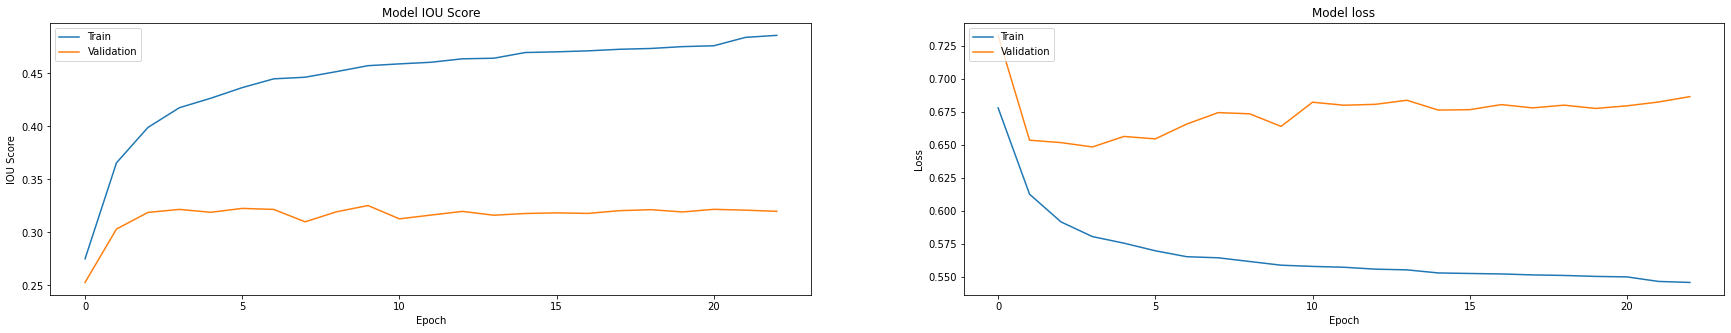

In [17]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 140ms/step


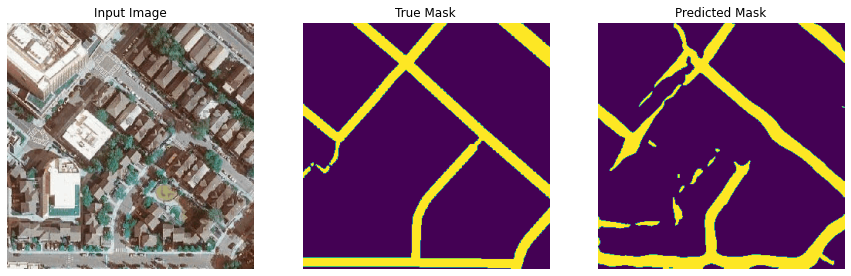

1/1 [==============================] - 0s 158ms/step


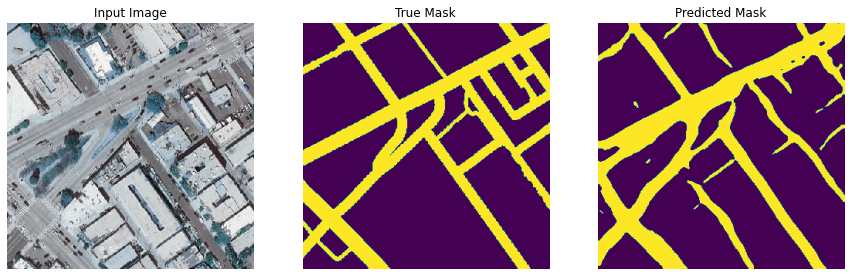

1/1 [==============================] - 0s 160ms/step


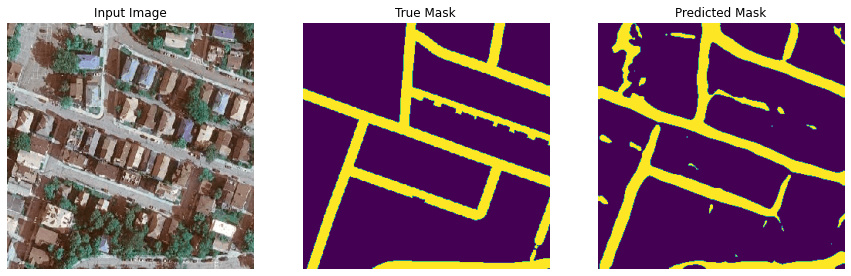

1/1 [==============================] - 0s 167ms/step


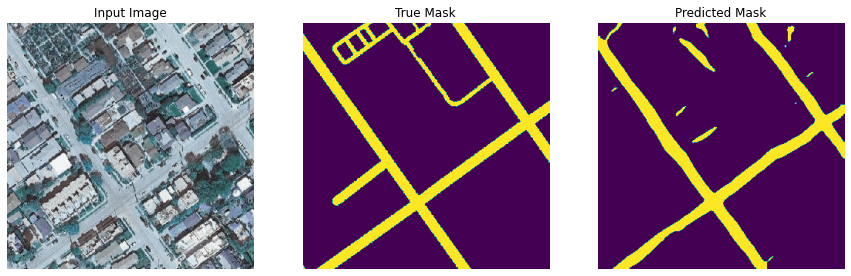

1/1 [==============================] - 0s 160ms/step


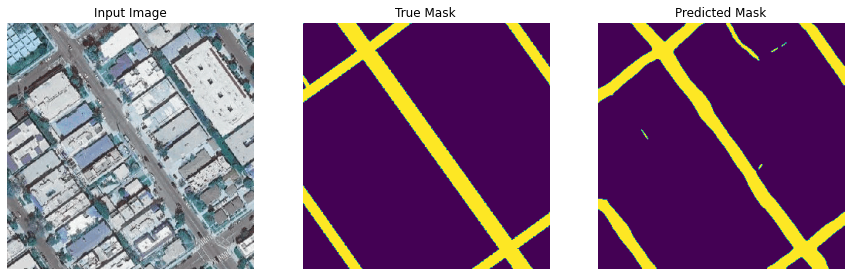

In [18]:
iou_scores = 0

for image, mask in test.take(5):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    display([
                sample_image,
                sample_mask,
                create_mask(output_model)
                ])
    # print(create_mask(output_model))